In [1]:
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
else:
  IN_COLAB = False
  HDFS_PATH = 'hdfs://localhost:9000/user/'

In [2]:
if IN_COLAB:
  # Installing JDK, Hadoop, Spark
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  !wget -q http://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
  !tar xf spark-3.2.1-bin-hadoop3.2.tgz
  !pip install -q findspark

  # TODO this part below will be removed before we deliver the project
  # Authenticate and create the PyDrive client.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  #downloaded = drive.CreateFile({'id': '1hSexq5mSu32ARQ4lxZPfD7pdtmtY1DQU'}) 
  #downloaded.GetContentFile('ny_accidents-clean.csv') 

  downloaded = drive.CreateFile({'id': '1puL-m5qP_0QroAHOTHmEWObJ-MX0TMXC'}) 
  downloaded.GetContentFile('ny_accidents-clean-2.csv') 

  # Environmental variables
  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession, functions as F
from pyspark.sql.functions import dayofweek
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
import plotly.graph_objs as go

#### Hilfsfunktionen

In [4]:
def plotFeatureImportance(importances):
  dt_importances = pd.Series(importances)

  fig, ax = plt.subplots(figsize=(15,5))
  dt_importances.plot.bar(ax=ax)
  ax.set_title("Feature importances")
  ax.set_ylabel("Mean decrease in impurity")
  fig.tight_layout()

def getFilteredImportances(f_importances):
  imp = pd.Series(f_importances, index=FEATURES)

  sorted_importances = imp.sort_values(ascending=False)
  sorted_importances = sorted_importances[0:10]
  return sorted_importances

def addOverviewPlot(title, ax, y_pred, y_test):
  sns.scatterplot(y_test, y_pred, ax=ax)
  ax.set_title(title)
  ax.set_xlabel('Severity')
  ax.set_ylabel('Vorausgesagte Severity')
  z = np.polyfit(y_test, y_pred, 1)
  p = np.poly1d(z)
  ax.plot(y_test, p(y_test), color='red')

### Init & Data load

In [5]:
# Create Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/02 22:33:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/02 22:33:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/05/02 22:33:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
/Users/herbishtini/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
file_name = 'ny_accidents-clean-route.csv' 
df = spark.read.csv(file_name if IN_COLAB else HDFS_PATH + file_name, header=True, inferSchema=True)
df.show(5)

22/05/02 22:33:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------+--------------+-----------+------------+--------------+---------------+-----------------+-------+---------------+--------------+------------+----------------+---------------+--------------------+-----------------------+------------------------+----------------------+---------------------+----------------------------+----------------------------+-------------------------------+--------------------------+-------------------------------+----------------------+----------------------------------+------------------+--------------------+-------------+------------+---------------+---------------+------------+---------------+-------------+-------------+-----------------+---------------+------------------+
|Severity|Zipcode|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity|Traffic_Calming|Traffic_Signal|Turning_Loop|Start_Time_month|Start_Time_hour|Start_Time_dayofweek|Weather_Condition_Clear|Weather_Condition_Cloudy|Weather_Condit

### Datenvorbereitung

In [7]:
df_clean = df.drop('Start_Time_minute', 'ZipCode')
FEATURES = list(set(df_clean.columns) - set(['Severity']))
FEATURES

['Sunrise_Sunset_Night',
 'Weather_Condition_Scattered Clouds',
 'Humidity(%)',
 'Visibility(mi)',
 'Weather_Condition_Partly Cloudy',
 'Weather_Condition_Fog',
 'Weather_Condition_Mostly Cloudy',
 'Start_Time_hour',
 'Weather_Condition_Rain',
 'Precipitation(in)',
 'Weather_Condition_Light Rain',
 'Wind_Speed(mph)',
 'County_Kings',
 'County_Rensselaer',
 'Temperature(F)',
 'Weather_Condition_Overcast',
 'County_Bronx',
 'Weather_Condition_Light Snow',
 'Turning_Loop',
 'County_Putnam',
 'County_Albany',
 'County_Richmond',
 'Weather_Condition_Cloudy',
 'Weather_Condition_Clear',
 'Weather_Condition_Fair',
 'Traffic_Calming',
 'Pressure(in)',
 'County_Columbia',
 'Amenity',
 'Traffic_Signal',
 'County_New York',
 'County_Queens',
 'County_Dutchess',
 'County_Westchester',
 'Sunrise_Sunset_Day',
 'Start_Time_dayofweek',
 'Start_Time_month']

In [8]:
va = VectorAssembler(inputCols = FEATURES, outputCol='features')
va_df = va.transform(df_clean)
va_df = va_df.select(['features', 'Severity'])
va_df.show(5)

+--------------------+--------+
|            features|Severity|
+--------------------+--------+
|(37,[2,3,7,8,9,11...|       2|
|(37,[0,2,3,7,9,10...|       2|
|(37,[0,2,7,9,11,1...|       2|
|(37,[0,2,3,7,10,1...|       2|
|(37,[0,2,3,7,10,1...|       4|
+--------------------+--------+
only showing top 5 rows



In [9]:
# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = va_df.randomSplit([0.8, 0.2], seed=42)
print("Training Dataset Anzahl: " + str(trainingData.count()))
print("Test Dataset Anzahl: " + str(testData.count()))

Training Dataset Anzahl: 42675
Test Dataset Anzahl: 10605


### DecisionTree

In [10]:
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Severity') # , maxDepth = 3

evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction")

# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
             .addGrid(dtc.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(dtc.maxBins, [10, 20, 40, 80, 100])
             .build())

# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = dtc,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)

# Train model.  This also runs the indexer.
dt_model = dtcv.fit(trainingData)

# Make predictions.
dt_preds = dt_model.transform(testData)

# Select example rows to display.
dt_preds.select("prediction", "Severity", "features").show(5)

22/05/02 22:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1093.0 KiB
22/05/02 22:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1217.2 KiB
22/05/02 22:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1061.7 KiB
22/05/02 22:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1183.6 KiB
22/05/02 22:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1017.5 KiB
22/05/02 22:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1134.8 KiB
22/05/02 22:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1018.0 KiB
22/05/02 22:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1126.5 KiB
22/05/02 22:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1018.3 KiB
22/05/02 22:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1128.2 KiB
22/05/02 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1093.0 KiB
22/05/02 22:34:36 WAR

22/05/02 22:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1845.6 KiB
22/05/02 22:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1122.7 KiB
22/05/02 22:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1060.2 KiB
22/05/02 22:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1168.5 KiB
22/05/02 22:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1266.8 KiB
22/05/02 22:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1355.3 KiB
22/05/02 22:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1434.7 KiB
22/05/02 22:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1500.0 KiB
22/05/02 22:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1557.5 KiB
22/05/02 22:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1606.0 KiB
22/05/02 22:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1641.1 KiB
22/05/02 22:35:25 WAR

22/05/02 22:36:13 WARN DAGScheduler: Broadcasting large task binary with size 1579.4 KiB
22/05/02 22:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1608.3 KiB
22/05/02 22:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1629.1 KiB
22/05/02 22:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
22/05/02 22:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1073.0 KiB
22/05/02 22:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1172.6 KiB
22/05/02 22:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1257.8 KiB
22/05/02 22:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/05/02 22:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1403.5 KiB
22/05/02 22:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1460.4 KiB
22/05/02 22:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1509.1 KiB
22/05/02 22:36:18 WAR

22/05/02 22:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1569.2 KiB
22/05/02 22:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1591.8 KiB
22/05/02 22:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1607.5 KiB
22/05/02 22:37:20 WARN DAGScheduler: Broadcasting large task binary with size 1117.2 KiB
22/05/02 22:37:20 WARN DAGScheduler: Broadcasting large task binary with size 1257.3 KiB
22/05/02 22:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1036.9 KiB
22/05/02 22:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1166.4 KiB
22/05/02 22:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
22/05/02 22:37:27 WARN DAGScheduler: Broadcasting large task binary with size 1062.3 KiB
22/05/02 22:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1053.2 KiB
22/05/02 22:37:31 WARN DAGScheduler: Broadcasting large task binary with size 1117.2 KiB
22/05/02 22:37:31 WAR

+----------+--------+--------------------+
|prediction|Severity|            features|
+----------+--------+--------------------+
|       2.0|       2|(37,[0,1,2,3,7,11...|
|       3.0|       4|(37,[0,1,2,3,7,11...|
|       2.0|       2|(37,[0,1,2,3,7,11...|
|       2.0|       2|(37,[0,1,2,3,7,11...|
|       2.0|       2|(37,[0,1,2,3,7,11...|
+----------+--------+--------------------+
only showing top 5 rows



#### Genauigkeit

In [11]:
acc = evaluator.evaluate(dt_preds, {evaluator.metricName: "accuracy"})
print("Accuracy %g" % acc)

Accuracy 0.844696


#### F1, Weighted Precision, Weighted Recall

In [12]:
# Select (prediction, true label) and compute test error

lRf1=evaluator.evaluate(dt_preds, {evaluator.metricName: "f1"})
print("MultiClass F1 -------------------------------: %g"%lRf1)
lRwP=evaluator.evaluate(dt_preds, {evaluator.metricName: "weightedPrecision"})
print("MultiClass Weighted Precision ---------------: %g"%lRwP)
lRwR=evaluator.evaluate(dt_preds, {evaluator.metricName: "weightedRecall"})
print("MultiClass Weighted Recall ------------------: %g"%lRwR)

MultiClass F1 -------------------------------: 0.834352
MultiClass Weighted Precision ---------------: 0.826727
MultiClass Weighted Recall ------------------: 0.844696


In [13]:
dt_model.bestModel

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_9fd2a333d452, depth=20, numNodes=7769, numClasses=5, numFeatures=37

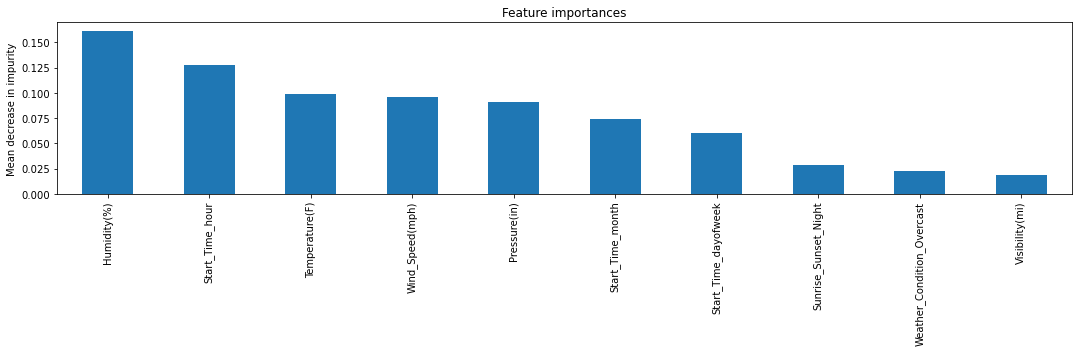

In [14]:
plotFeatureImportance(getFilteredImportances(dt_model.bestModel.featureImportances.toArray()))

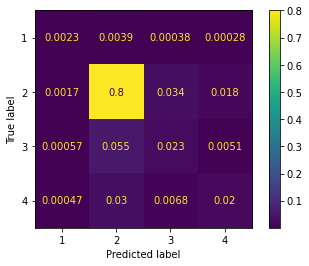

In [15]:
conf_dt_sev = dt_preds.select('Severity').toPandas()
conf_dt_pred = dt_preds.select('prediction').toPandas()

dt_cm = confusion_matrix(conf_dt_sev, conf_dt_pred, normalize='all')
dt_cmd = ConfusionMatrixDisplay(dt_cm, display_labels=[1, 2, 3, 4])

dt_cmd.plot()

### MLP

In [16]:
mlpc = MultilayerPerceptronClassifier(featuresCol="features", labelCol="Severity", predictionCol="prediction", layers=[len(FEATURES), 6, 6], seed=123) 

mlpc_evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction")

# Create ParamGrid for Cross Validation
mlpc_paramGrid = (ParamGridBuilder()
             .addGrid(mlpc.layers, [[len(FEATURES), 22, 26], [len(FEATURES), 50, 30], [len(FEATURES), 150, 100]])
             .addGrid(mlpc.maxIter, [1000]) # , 300, 500
             .build())

# Create 5-fold CrossValidator
mlpc_cv = CrossValidator(estimator = mlpc,
                        evaluator = mlpc_evaluator,
                        estimatorParamMaps = mlpc_paramGrid,
                        numFolds = 5)

# Train model.  This also runs the indexer.
mlpc_model = mlpc_cv.fit(trainingData)

# Make predictions.
mlpc_preds = mlpc_model.transform(testData)

22/05/02 22:37:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/02 22:37:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/05/02 22:38:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/02 22:38:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


KeyboardInterrupt: 

In [ ]:
conf_mlpc_sev = mlpc_preds.select('Severity').toPandas()
conf_mlpc_pred = mlpc_preds.select('prediction').toPandas()

mlpc_cm = confusion_matrix(conf_mlpc_sev, conf_mlpc_pred, normalize='all')
mlpc_cmd = ConfusionMatrixDisplay(mlpc_cm, display_labels=[1, 2, 3, 4])

mlpc_cmd.plot()

Modeling speichern

In [18]:
dt_model.save('decision-tree-model')